# Dog Breed identification

## Checking GPU 
GPU with 7.0+ compute combatibility is needed for mixed precision

In [1]:
!nvidia-smi

Sat Aug  6 21:16:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    13W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing helper functions

In [3]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,compare_historys

## Downloading dataset from tensorflow datasets

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds


(train_data,test_data),ds_info=tfds.load('stanford_dogs',
                                         split=['train','test'],
                                         shuffle_files=True, #shuffles the tensors
                                         as_supervised=True, #data gets returned in tuple format with data,labels
                                         with_info=True)

## Exploring the dataset

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [6]:
class_names=ds_info.features['label'].names

In [7]:
sample=train_data.take(1)

In [8]:
# info about our training sample
for image,label in sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class (tensor form) :{label},
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (1879, 1388, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class (tensor form) :63,
  Class name (str form): n02101006-gordon_setter
  


In [9]:
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=254>)

We can see that:
1. Image shapes have change shapes
2. The datatype is unit8. Not compatible with 
3. Labels are encoded in decimal and not in one hot
4. The data is also not normalized

### Plotting an image

(-0.5, 1387.5, 1878.5, -0.5)

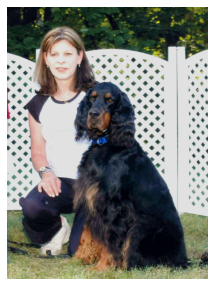

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis(False)

## Preprocessing the data

What we know about data:
* In `uint8` datatype
* Comprised of all different size tensors(different size images)
* Not scaled ( the pixel values are between 0 & 255)

What we know about NN:
* Data in `float32` dtype (or mixed precision `float16` and `float32`)
* Data should be in same size
* Scaled data (values between 0 & 1)  
* Data in batches

Since we will be using efficientnet we dont need to rescale 

In [11]:
def preprocess_image(image,label,img_shape=360):
  image=tf.image.resize(image,size=[img_shape,img_shape])
  return tf.cast(image,tf.float32),label # return a tuple of image and label

In [12]:
preprocessed_image=preprocess_image(image,label)[0]
print(f'Image before preprocessing\n Shape: {image.shape},\nDatatype: {image.dtype}')
print(f'Image before preprocessing\n Shape: {preprocessed_image.shape},\nDatatype: {preprocessed_image.dtype}')

Image before preprocessing
 Shape: (1879, 1388, 3),
Datatype: <dtype: 'uint8'>
Image before preprocessing
 Shape: (360, 360, 3),
Datatype: <dtype: 'float32'>


Now we can apply the preprocessing function to our data

In [13]:
train_data=train_data.map(preprocess_image,
                                  num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data=test_data.map(preprocess_image,
                                  num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

## Creating some callbacks
Creating two callbacks here

* Tensorboard callback
* Model checkpoint

In [14]:
# create tensorboard callback (import from helper function)
from helper_functions import create_tensorboard_callback

# ModelCheckPoint calllback to save the progress
checkpoint_path='feature_extraction_checkpoint/cp.ckpt'
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                    metric='val_acc',
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    verbose=0)

## Setting up mixed precision

Mixed precision allows faster training times and less memory consumption. For a deeper understanding of mixed precision training, check out the guide: https://www.tensorflow.org/guide/mixed_precision

In [15]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [16]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Creating a Feature extraction model

In [17]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomFlip('horizontal')],name='Data_augmentation')

In [18]:
# Setting up a base model
base_model=tf.keras.applications.EfficientNetV2B2(include_top=False)
base_model.trainable=False
#Setting up inputs
img_shape=(360,360,3)
inputs=tf.keras.layers.Input(shape=img_shape,name='Input_layer')


x=data_augmentation(inputs)
#passing input to base model
x=base_model(x,training=False)

#Average pooling layer
x=tf.keras.layers.GlobalAveragePooling2D()(x)

#Output layer with float32 precision
x=tf.keras.layers.Dense(len(class_names))(x)
outputs=tf.keras.layers.Activation('softmax',dtype=tf.float32,name='softmax_float32')(x)

model=tf.keras.Model(inputs,outputs)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 360, 360, 3)]     0         
                                                                 
 Data_augmentation (Sequenti  (None, 360, 360, 3)      0         
 al)                                                             
                                                                 
 efficientnetv2-b2 (Function  (None, None, None, 1408)  8769374  
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 120)               169080    
                                                             

In [20]:
for layer in model.layers:
  print(layer.name,layer.trainable)

Input_layer True
Data_augmentation True
efficientnetv2-b2 False
global_average_pooling2d True
dense True
softmax_float32 True


In [21]:
# Using sparse categorical crossentropy because of decimal labels
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

##Fitting and Evaluating the model

In [22]:
## Model starts to overfit after 3 epoch. Let's train it for 3 epochs only
history0=model.fit(train_data,
          epochs=3,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=int(0.20*len(test_data)),
          callbacks=[create_tensorboard_callback(dir_name='Dog_breed',
                                                 experiment_name='feature_extraction'),
                     model_checkpoint])

Saving TensorBoard log files to: Dog_breed/feature_extraction/20220806-211706
Epoch 1/3
375/375 [==============================] - 123s 291ms/step - loss: 1.6929 - accuracy: 0.6488 - val_loss: 0.3990 - val_accuracy: 0.9009
Epoch 2/3
375/375 [==============================] - 97s 252ms/step - loss: 0.7651 - accuracy: 0.7883 - val_loss: 0.3005 - val_accuracy: 0.9116
Epoch 3/3
375/375 [==============================] - 93s 240ms/step - loss: 0.6554 - accuracy: 0.8118 - val_loss: 0.2739 - val_accuracy: 0.9163


In [23]:
model.evaluate(test_data)

269/269 [==============================] - 28s 104ms/step - loss: 0.2687 - accuracy: 0.9190


[0.26873812079429626, 0.9189976453781128]

## Creating callbacks before Performing fine tuning

In [24]:
#checkpoint callback
checkpoint_path='fine_tune/cp.ckpt'
checkpoint=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                              monitor='val_loss',
                                              verbose=0,
                                              save_best_only=True,
                                              save_weights_only=True)


# Early stopping
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print when the lr is reduced
                                                 min_lr=1e-7)


## Perform the Fine tuning on the model

Since the dataset is small (12,000 for training). I'll only be unfreezing last 10 layers

In [25]:
model.layers[2].trainable=True

In [26]:
#setting all but last 10 to trainable
for layer in model.layers[2].layers[:-60]:
  layer.trainable=False

In [27]:
for layer in model.layers[2].layers:
  print(layer.name,layer.trainable)

input_1 False
rescaling False
normalization False
stem_conv False
stem_bn False
stem_activation False
block1a_project_conv False
block1a_project_bn False
block1a_project_activation False
block1b_project_conv False
block1b_project_bn False
block1b_project_activation False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_project_conv False
block2b_project_bn False
block2b_add False
block2c_expand_conv False
block2c_expand_bn False
block2c_expand_activation False
block2c_project_conv False
block2c_project_bn False
block2c_add False
block3a_expand_conv False
block3a_expand_bn False
block3a_expand_activation False
block3a_project_conv False
block3a_project_bn False
block3b_expand_conv False
block3b_expand_bn False
block3b_expand_activation False
block3b_project_conv False
block3b_project_bn False
bloc

In [28]:
## Recompiling
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
history1=model.fit(train_data,
                   epochs=100,
                   steps_per_epoch=len(train_data),
                   validation_data=test_data,
                   validation_steps=int(0.15*len(test_data)),
                   initial_epoch=history0.epoch[-1],
                   callbacks=[create_tensorboard_callback(dir_name='food vision',
                                                          experiment_name='fine_tuning'),
                              checkpoint,
                              early_stopping,
                              reduce_lr])

Saving TensorBoard log files to: food vision/fine_tuning/20220806-212404
Epoch 3/100
375/375 [==============================] - 109s 255ms/step - loss: 0.5436 - accuracy: 0.8341 - val_loss: 0.2612 - val_accuracy: 0.9078 - lr: 1.0000e-04
Epoch 4/100
375/375 [==============================] - 91s 235ms/step - loss: 0.4566 - accuracy: 0.8568 - val_loss: 0.2728 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 5/100
375/375 [==============================] - ETA: 0s - loss: 0.3978 - accuracy: 0.8734
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
375/375 [==============================] - 88s 230ms/step - loss: 0.3978 - accuracy: 0.8734 - val_loss: 0.2984 - val_accuracy: 0.8953 - lr: 1.0000e-04
Epoch 6/100
375/375 [==============================] - 87s 227ms/step - loss: 0.2950 - accuracy: 0.9054 - val_loss: 0.2746 - val_accuracy: 0.9102 - lr: 2.0000e-05


In [30]:
model.evaluate(test_data)

269/269 [==============================] - 28s 103ms/step - loss: 0.2686 - accuracy: 0.9160


[0.2686167359352112, 0.9159673452377319]

In [31]:
model.save('fine_tuned.h5')

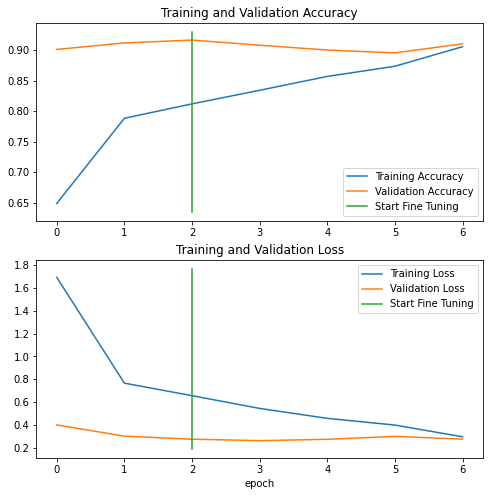

In [33]:
compare_historys(history0,history1,3)

## Evaluating Fine Tuned model

In [34]:
import numpy as np
y_pred = []
y_true = []

for image_batch, label_batch in test_data:
   y_true.append(label_batch)
   preds = model.predict(image_batch)
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

### Creating a Classification report

In [35]:
from sklearn.metrics import classification_report

In [36]:
print(classification_report(correct_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        52
           1       0.95      0.89      0.92        85
           2       0.98      0.85      0.91       152
           3       0.92      0.94      0.93        49
           4       0.85      0.87      0.86       114
           5       0.96      0.93      0.95        88
           6       0.97      0.98      0.97        96
           7       0.93      0.86      0.89        72
           8       0.88      0.82      0.85        72
           9       0.99      0.99      0.99       139
          10       0.93      0.99      0.95        75
          11       0.91      0.89      0.90        95
          12       0.98      0.97      0.97        87
          13       0.96      0.96      0.96        71
          14       0.98      0.88      0.93        59
          15       0.76      0.85      0.80        53
          16       0.86      0.77      0.81        57
          17       0.93    

### Creating a confusion matrix

In [37]:
from helper_functions import make_confusion_matrix

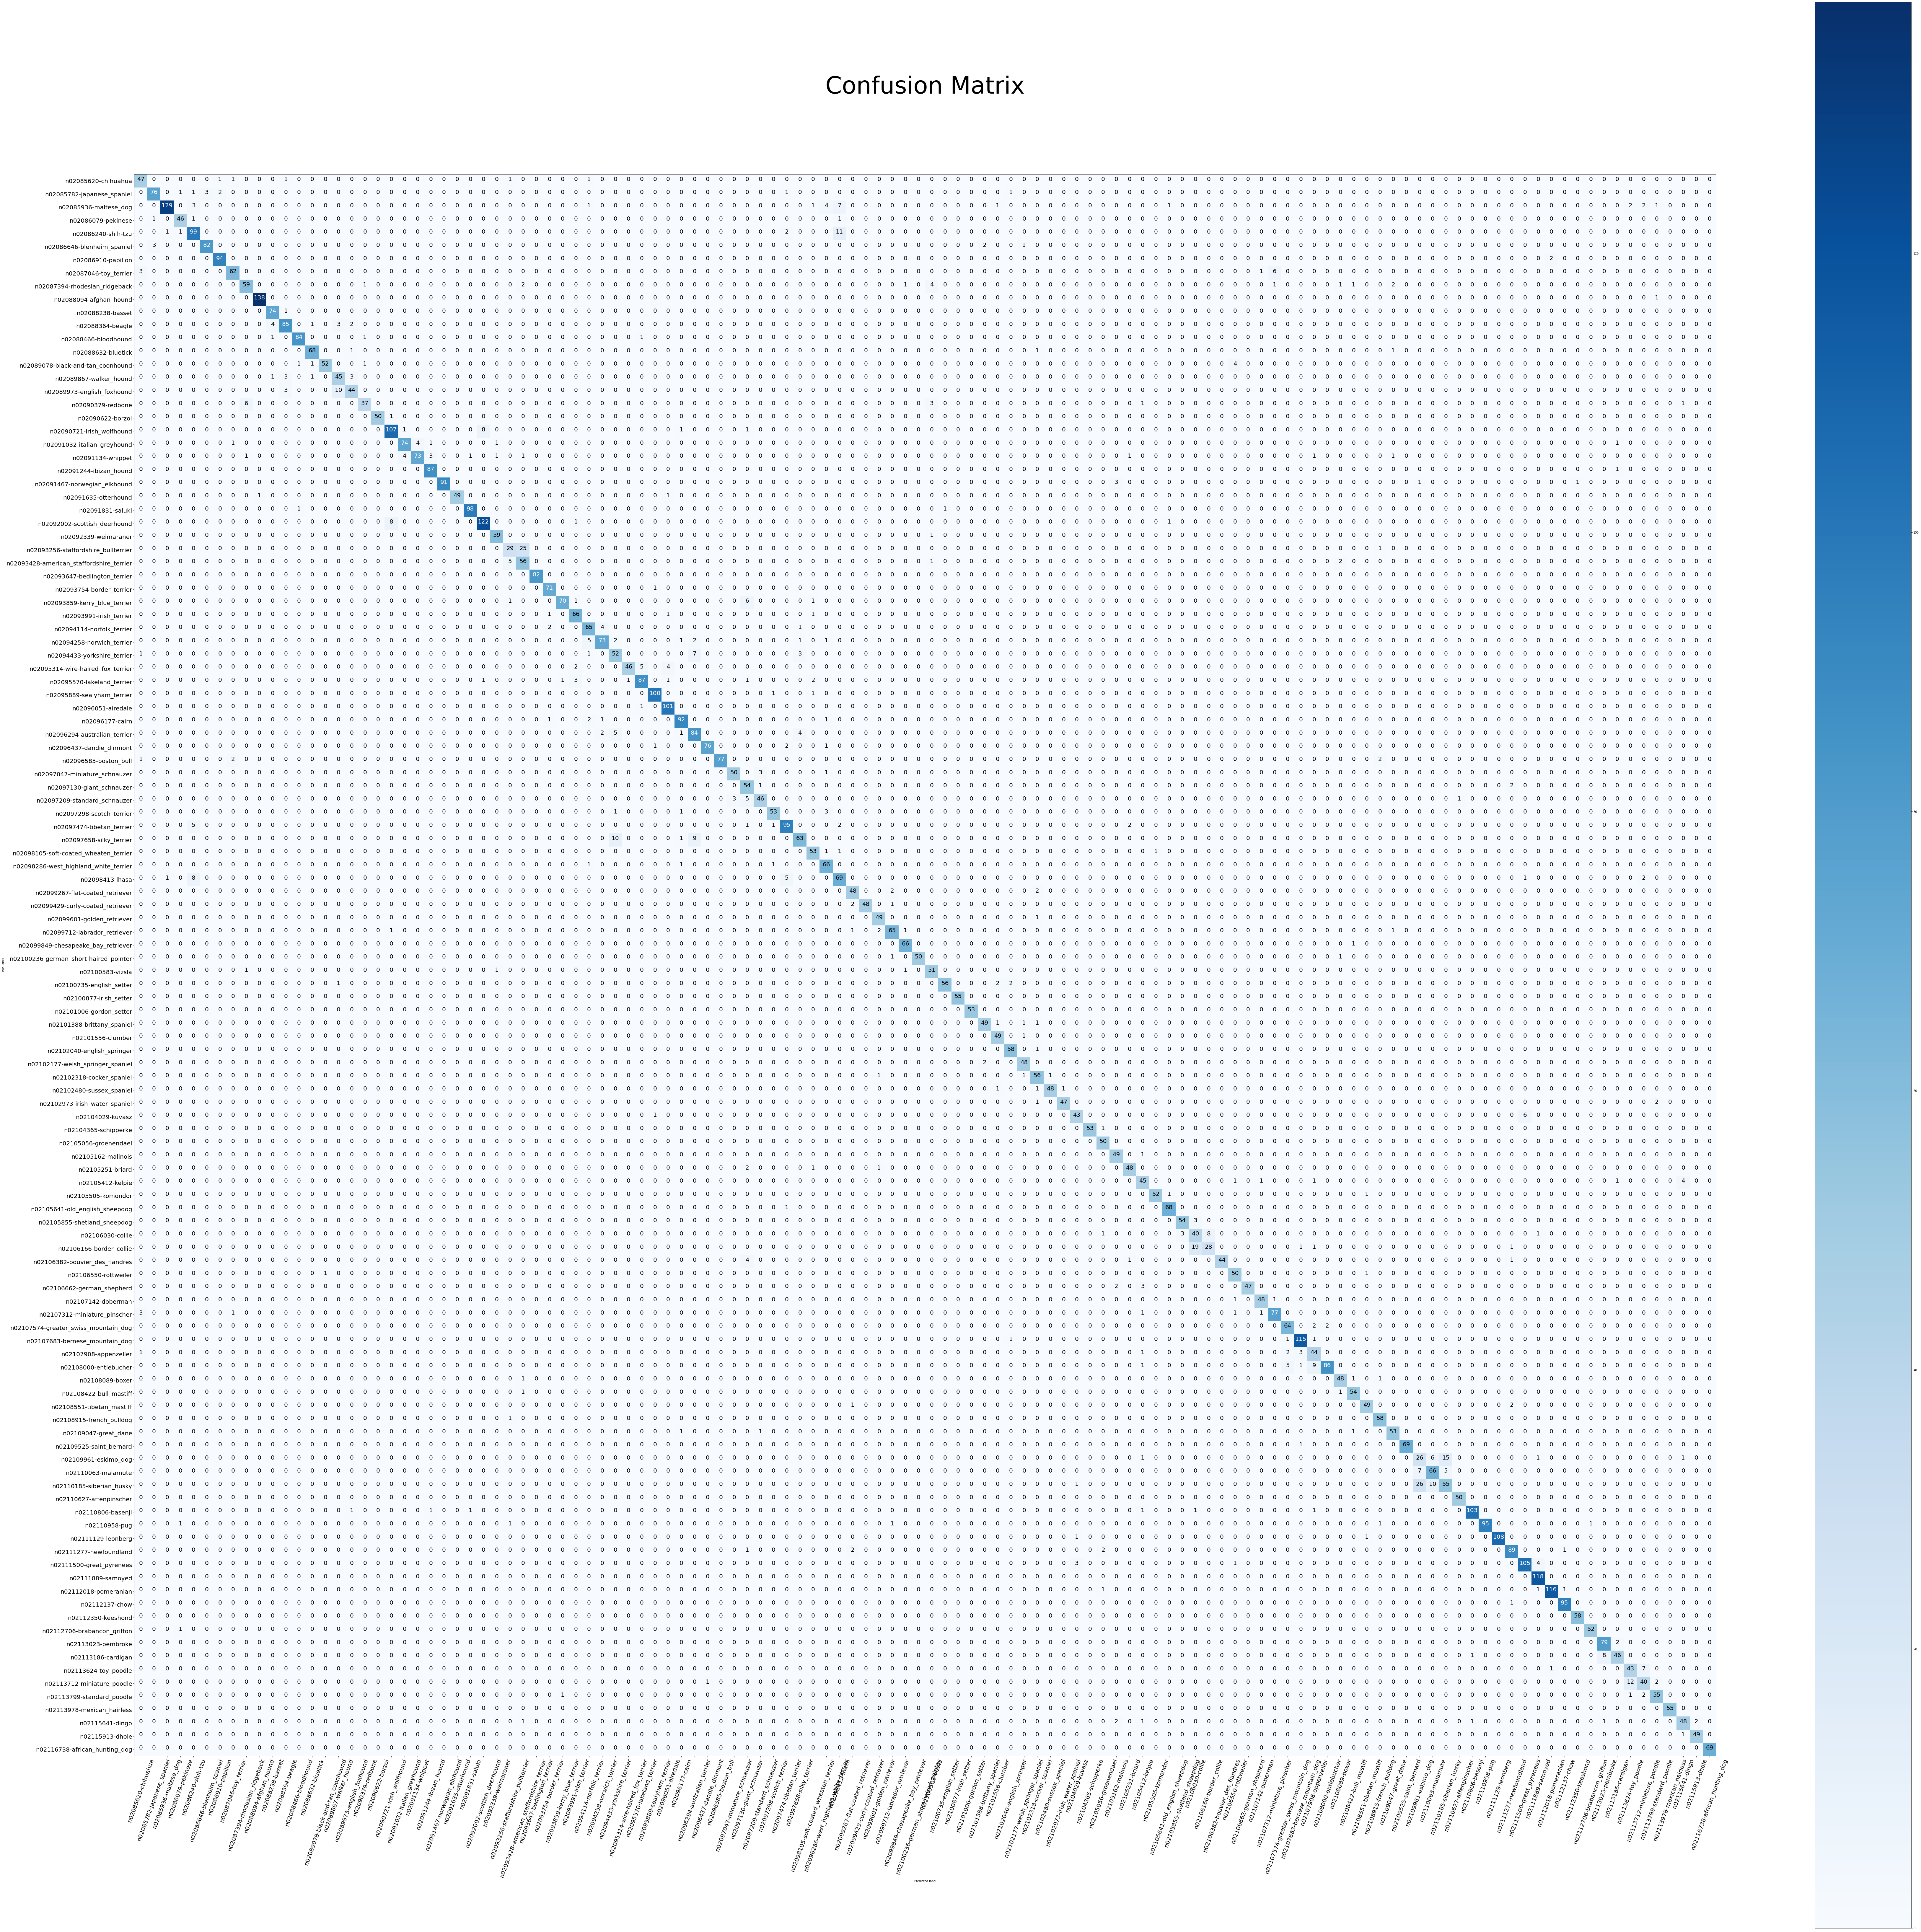

In [38]:
make_confusion_matrix(correct_labels,predicted_labels,
                      classes=class_names,
                      figsize=(120,120),text_size=20,savefig=False)

### Plotting F1-scores

In [39]:
classification_report_dict=classification_report(correct_labels,predicted_labels,output_dict=True)

In [40]:
f1_scores={}
for k,v in classification_report_dict.items():
  if k=='accuracy':
    break
  else:
    #add class names and f1_scores to new dict
    f1_scores[class_names[int(k)]]=v['f1-score']

In [41]:
#turn f1-score to dataframe
import pandas as pd
f1_scores_df=pd.DataFrame({'class_names':list(f1_scores.keys()),
                           'f1-score':list(f1_scores.values())}).sort_values('f1-score',ascending=False)

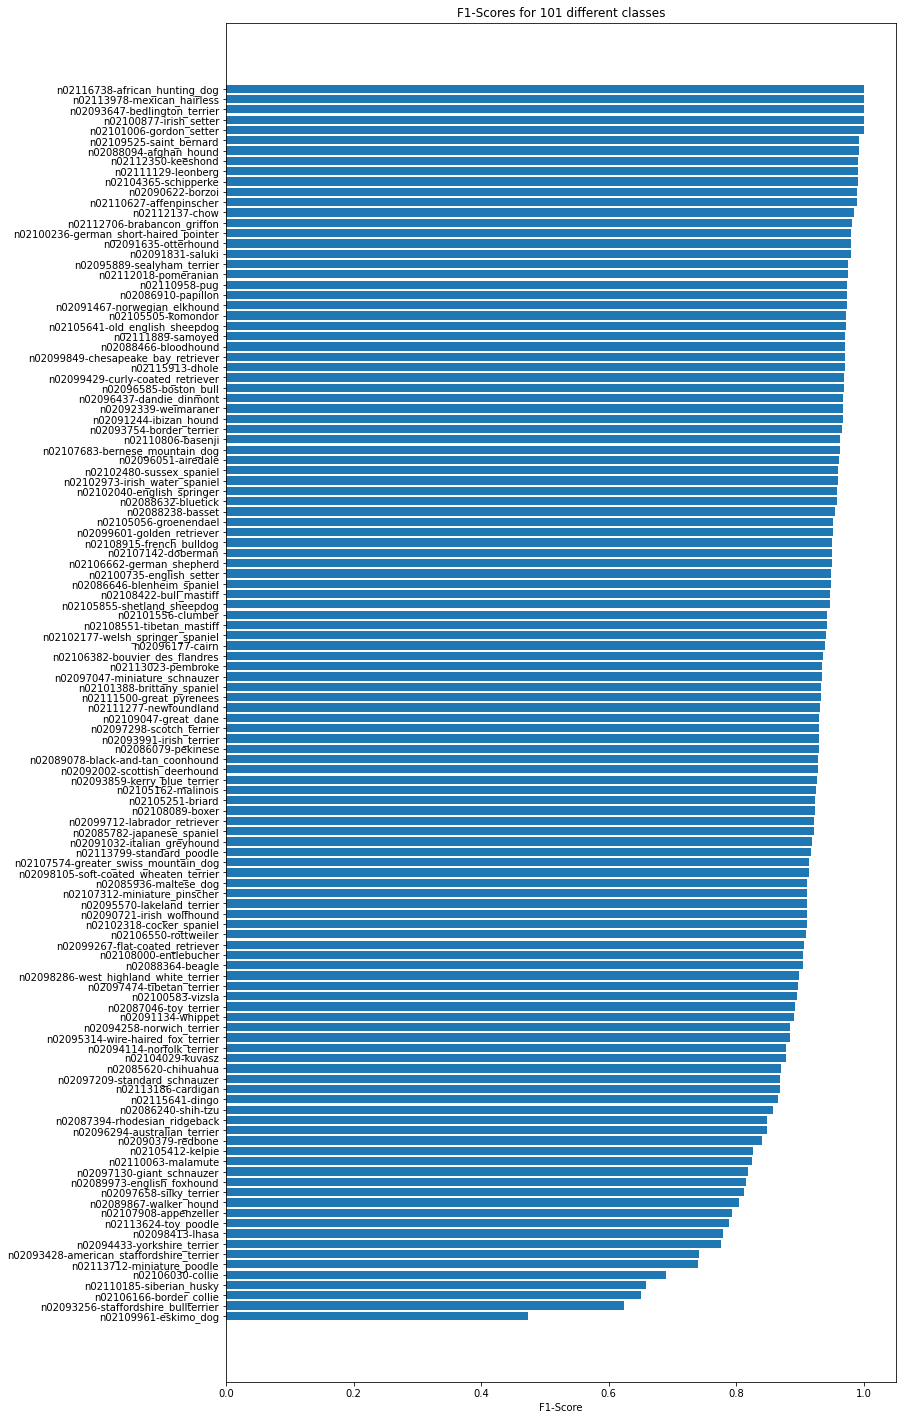

In [42]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(figsize=(12,25))
#creates bar chart
scores=ax.barh(range(len(f1_scores_df)),f1_scores_df['f1-score'].values)
#sets no of ticks
ax.set_yticks(range(len(f1_scores_df)))
#sets labels for ticks
a=ax.set_yticklabels(f1_scores_df['class_names'])

ax.set_xlabel('F1-Score')
ax.set_title('F1-Scores for 101 different classes')
#invert the ais
ax.invert_yaxis()

### Visualizing Random images from the dataset

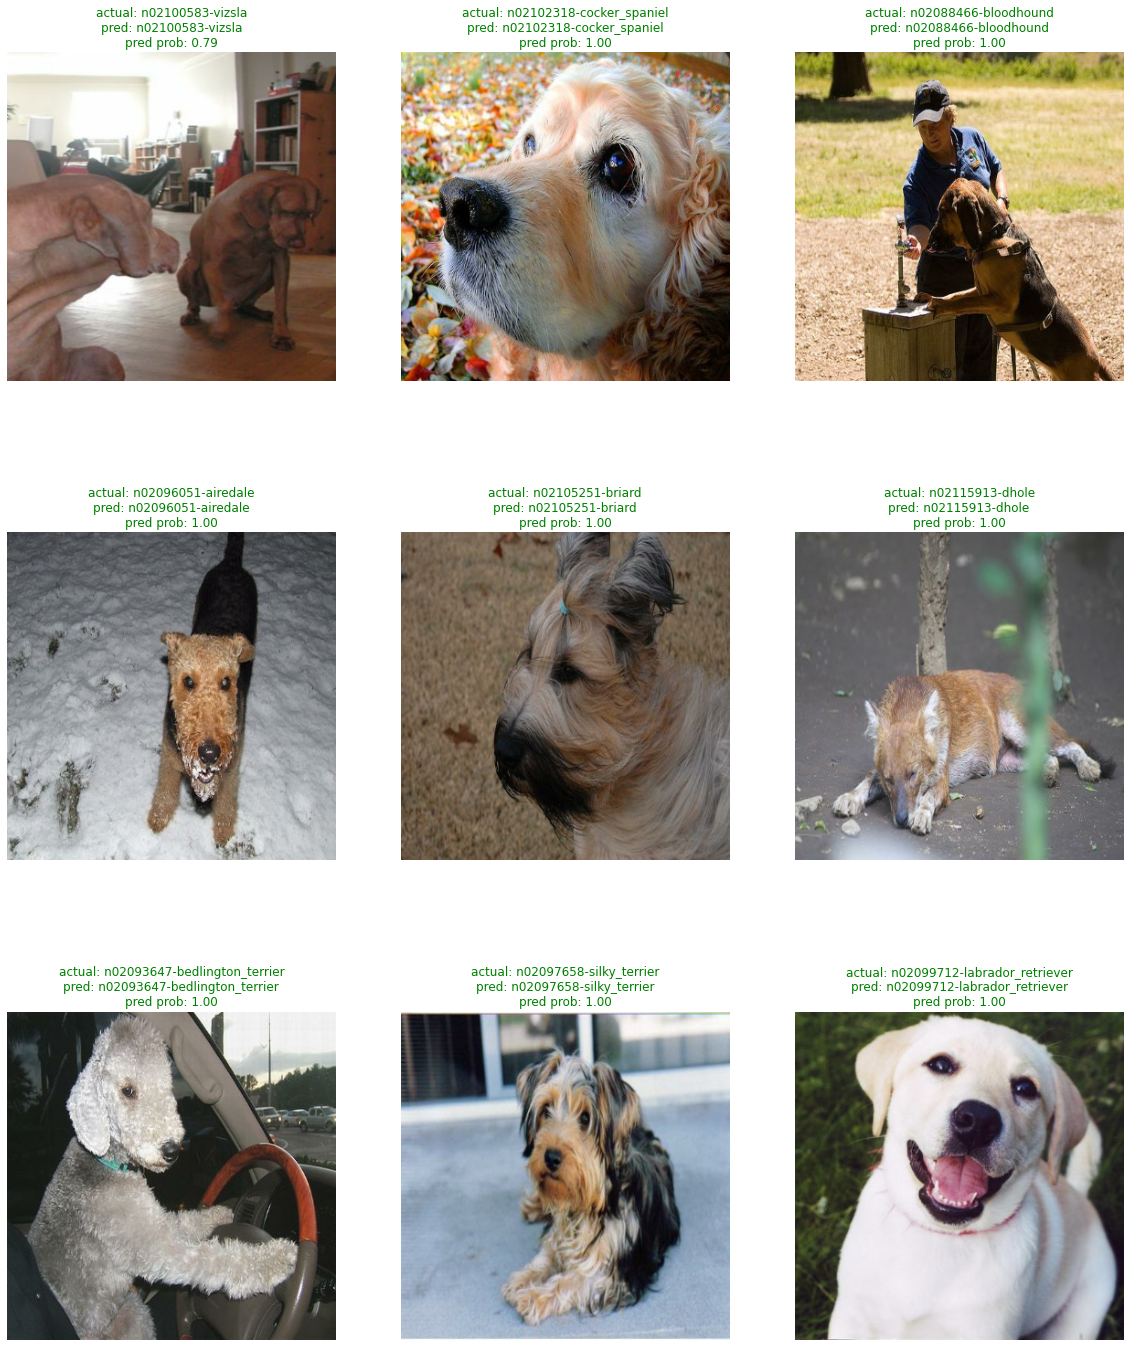

In [46]:
import random
plt.figure(figsize=(20,25))
random_choices=random.sample(range(0, 31), 9)
for img,label in test_data.take(1):
  for j,i in enumerate(random_choices):

    pred_prob=model.predict(tf.expand_dims(img[i],axis=0))
    pred_class=class_names[pred_prob.argmax()]
    class_name=class_names[label[i]]

    #plot image
    plt.subplot(3,3,j+1)
    plt.imshow(img[i]/255.)  #matplotlib needs normalized images
    if class_name==pred_class:
      title_color='g'
    else:
      title_color='r'
    plt.title(f'actual: {class_name}\npred: {pred_class}\npred prob: {pred_prob.max():.2f}',c=title_color)
    plt.axis(False)